# Introduction to Synthetic Population Generation

In [48]:
from pathlib import Path

import pandas as pd

from caveat.data.synth import ActivityGen
from caveat.data.utils import generate_population_conditional, trace_to_pam
from caveat.describe.times import (
    joint_time_distributions_plot,
    times_distributions_plot,
)
from caveat.describe.transitions import sequence_prob_plot

In [49]:
write_path = Path("tmp")
n = 10000

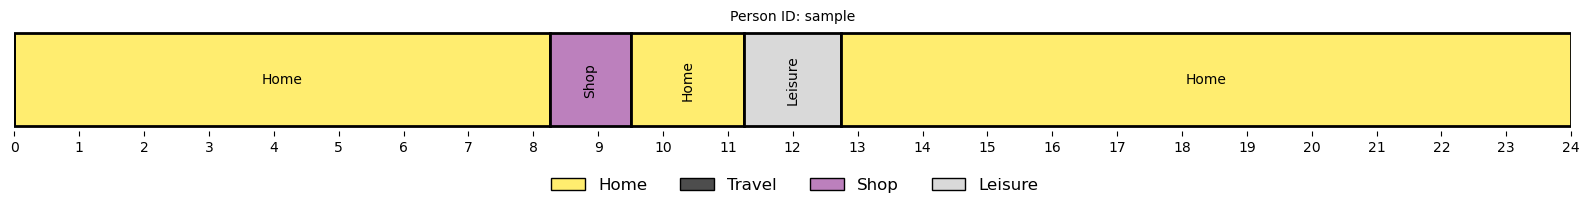

In [50]:
# FT worker generator
ftw = ActivityGen()
config = ftw.transition_config.copy()
for _, kv in config.items():
    for k, v in kv.items():
        if k in ["work"]:
            for i, (a, b) in enumerate(v):
                v[i] = (a, b * 10)
        if k in ["education", "shop", "leisure"]:
            for i, (a, b) in enumerate(v):
                v[i] = (a, b / 10)
ftw.build(config)

trace = ftw.run()
plan = trace_to_pam(trace, ftw.map)
plan.plot()

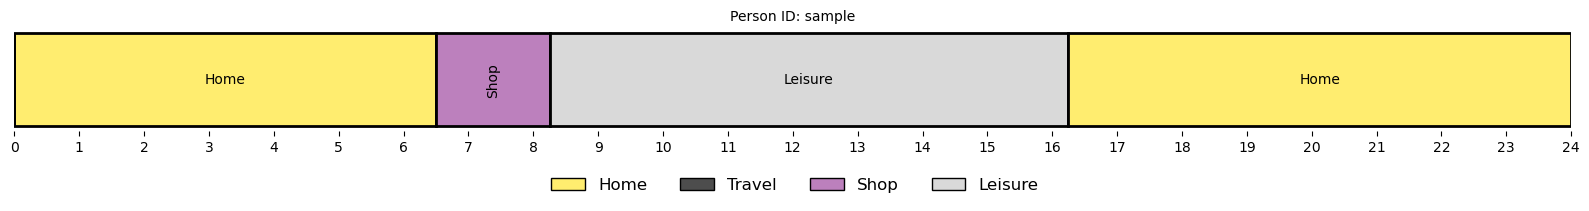

In [51]:
# PT worker generator
ptw = ActivityGen()
config = ptw.transition_config.copy()
for o, kv in config.items():
    for k, v in kv.items():
        if not o == "work":
            continue
        if k == "work":
            for i, (a, b) in enumerate(v):
                v[i] = (a, b / 100)
        if k in ["shop", "leisure"]:
            for i, (a, b) in enumerate(v):
                v[i] = (a, b * 100)
ptw.build(config)

trace = ptw.run()
plan = trace_to_pam(trace, ptw.map)
plan.plot()

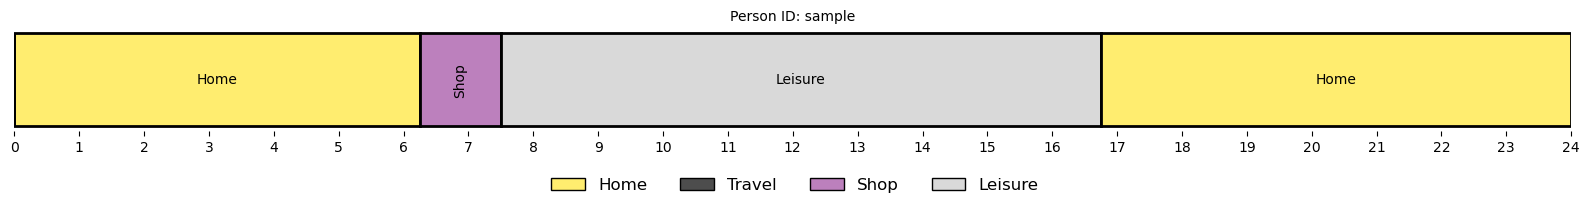

In [52]:
# Leisure generator
neet = ActivityGen()
config = neet.transition_config.copy()
for _, kv in config.items():
    for k, v in kv.items():
        if k in ["work", "education"]:
            for i, (a, b) in enumerate(v):
                v[i] = (a, 0)
        if k in ["shop", "leisure"]:
            for i, (a, b) in enumerate(v):
                v[i] = (a, b * 10)

neet.build(config)

trace = neet.run()
plan = trace_to_pam(trace, neet.map)
plan.plot()

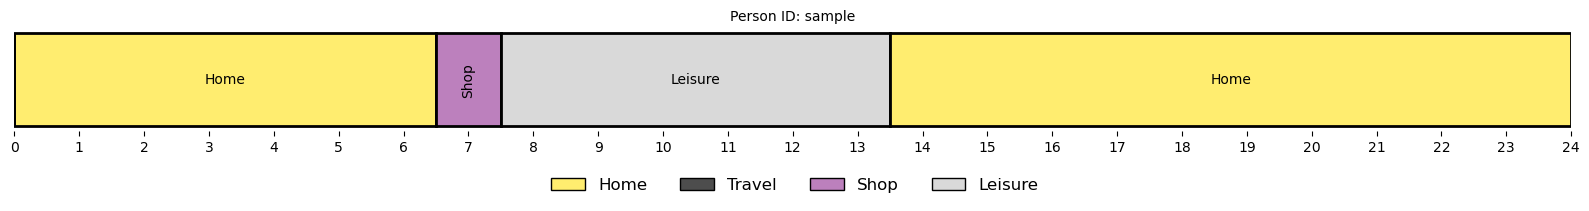

In [53]:
# FTE generator
fte = ActivityGen()
config = fte.transition_config.copy()
for _, kv in config.items():
    for k, v in kv.items():
        if k == "work":
            for i, (a, b) in enumerate(v):
                v[i] = (a, 0)
        if k == "education":
            for i, (a, b) in enumerate(v):
                v[i] = (a, b * 100)

fte.build(config)

trace = fte.run()
plan = trace_to_pam(trace, fte.map)
plan.plot()

In [54]:
population = generate_population_conditional(gens=(ftw, ptw, neet, fte), size=n)
population.act = population.act.map(ftw.map)
population = population[
    ["pid", "act", "start", "end", "duration", "gender", "age", "employment"]
]
population

,pid,act,start,end,duration,gender,age,employment
0,0,home,0,420,420,M,41,NEET
1,0,leisure,420,675,255,M,41,NEET
2,0,shop,675,885,210,M,41,NEET
3,0,home,885,1440,555,M,41,NEET
4,1,home,0,405,405,M,6,FTE
...,...,...,...,...,...,...,...,...
43956,9998,home,810,1440,630,F,74,PTW
43957,9999,home,0,390,390,M,72,FTW
43958,9999,shop,390,465,75,M,72,FTW
43959,9999,leisure,465,975,510,M,72,FTW


In [55]:
population.to_csv(write_path / "combined.csv", index=False)
population[["pid", "act", "start", "end", "duration"]].to_csv(
    write_path / "schedules.csv", index=False
)
population[["pid", "gender", "age", "employment"]].drop_duplicates().to_csv(
    write_path / "attributes.csv", index=False
)


<Axes: xlabel='age', ylabel='duration'>

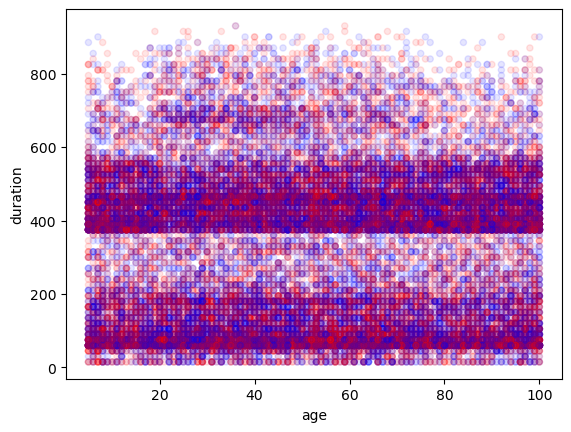

In [56]:
cs = population.gender.map({"M": "blue", "F": "red"})
population.plot(kind="scatter", x="age", y="duration", alpha=0.1, c=cs)

In [57]:
def describe_col(population, col: str) -> pd.DataFrame:
    description = population.groupby("act")[col].describe()[
        ["count", "mean", "std", "min", "max"]
    ]
    description["attribute"] = col
    return description


def describe_cols(population, cols: list[str]) -> pd.DataFrame:
    description = pd.concat(
        [describe_col(population, c) for c in cols], ignore_index=False
    )
    description = description.reset_index().set_index(["attribute", "act"])
    return description


describe_cols(population, ["start", "end", "duration"]).round()

count   mean    std    min     max
attribute act                                          
start     home     22219.0  456.0  435.0    0.0  1320.0
          leisure  10266.0  496.0  103.0  375.0  1260.0
          shop     11476.0  494.0  145.0  375.0  1170.0
end       home     22219.0  904.0  495.0  375.0  1440.0
          leisure  10266.0  825.0  190.0  405.0  1320.0
          shop     11476.0  587.0  165.0  390.0  1185.0
duration  home     22219.0  448.0  148.0   15.0   930.0
          leisure  10266.0  329.0  178.0   15.0   645.0
          shop     11476.0   93.0   66.0   15.0   525.0

In [58]:
subpops = {
    "males": population.loc[population.gender == "M"],
    "females": population.loc[population.gender == "F"],
    "young": population.loc[population.age < 25],
    "middle": population.loc[(population.age >= 25) & (population.age < 65)],
    "old": population.loc[population.age >= 65],
}

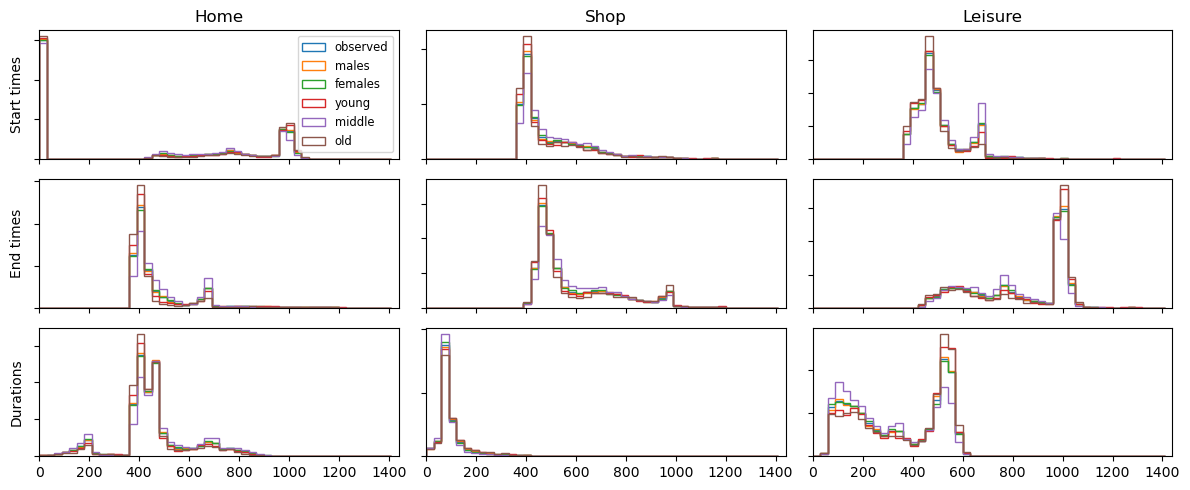

In [59]:
_ = times_distributions_plot(population, ys=subpops)

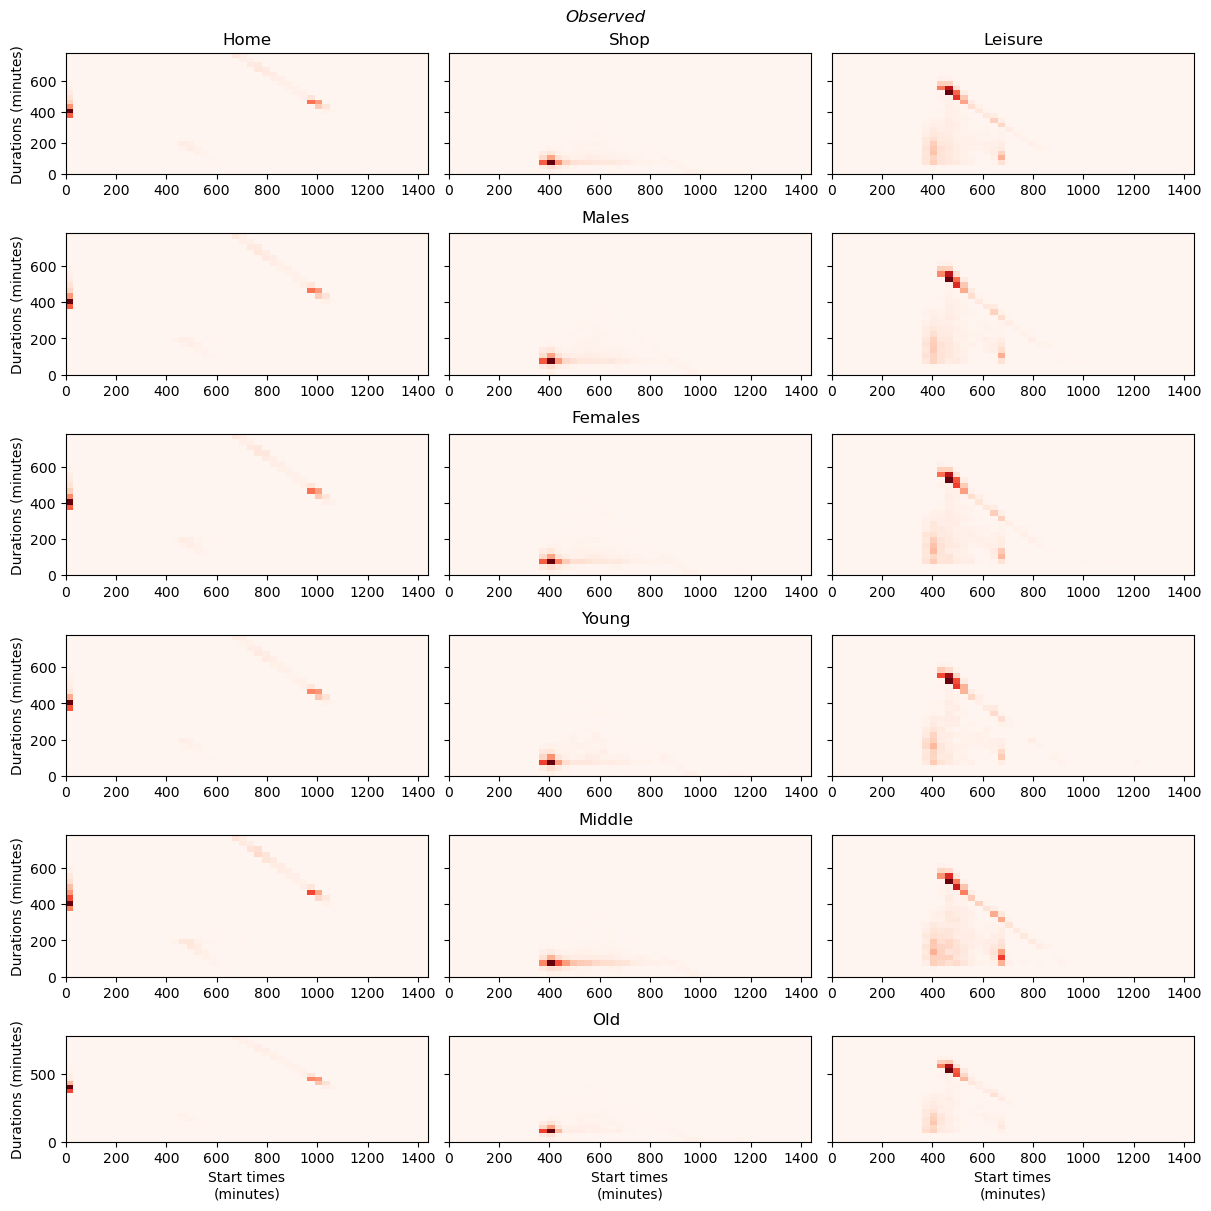

In [60]:
_ = joint_time_distributions_plot(population, ys=subpops, figsize=(12, 12))

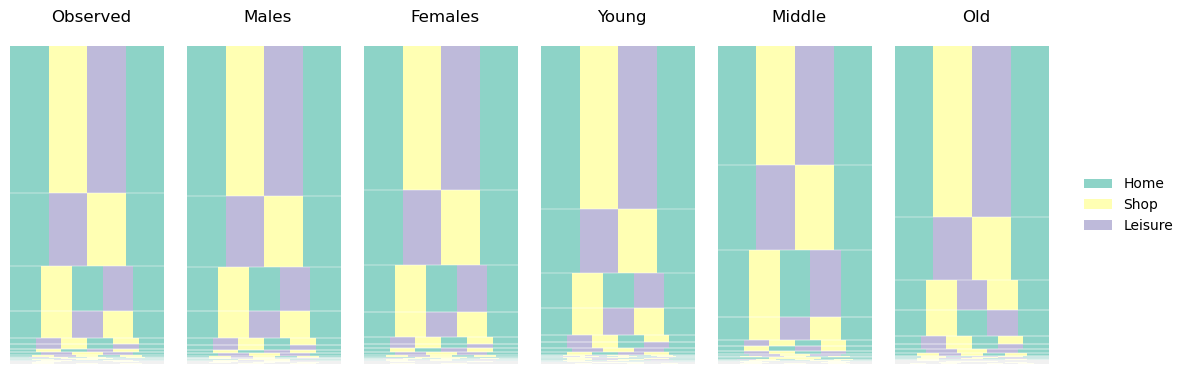

In [61]:
_ = sequence_prob_plot(population, ys=subpops, figsize=(12, 4))